# Analyzing scaling with mass 
October 13, 2021 
Venkitesh Ayyar

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [120]:
# sys.path.append('.')
# from modules_image_analysis import *

In [121]:
%matplotlib widget

In [122]:
from ipywidgets import *
from scipy import fftpack
from matplotlib.colors import LogNorm, PowerNorm, Normalize

In [123]:
# Load data
def f_get_data(fname):
    arr=np.loadtxt(fname,delimiter=',',dtype=str)
    arr_iters=arr[:,0].astype(int) # First element is iteration number
    arr1=arr[:,1:-1].astype(float)  # Skip last element (null string) and first (iteration)
    del(arr)
    # print(arr1.shape)
    L=int(np.sqrt(arr1.shape[1])) # Get lattice size
    num=arr1.shape[0]
    print(L)
    # a3=arr1.reshape(134,L,L) :  simple reshape doesn't do it in the correct order
    ## Reshape to 2D image
    arr2=np.empty((num,L,L),dtype=float)
    for i in range(num): 
        for x in range(L):
            for y in range(L):
                arr2[i,x,y]=arr1[i,x+y*L]

    print(arr2.shape)
    
    return arr2


def f_rescale(arr,mean):
    lst=[np.abs((i-mean)/mean) for i in arr]
    return np.array(lst)

In [7]:
# fname='../results_phi.txt'
# fname='../results_residue.txt'
# a1=f_get_data(fname)

In [125]:
arr_type='phi'
# arr_type='residue'
lst=['gs','jc']
lst2=['results_{0}_{1}.txt'.format(arr_type,i) for i in lst]

num=len(lst)
arr_lst=[]
for i in range(num):     
    fname='../'+lst2[i]
    print(fname)
    arr_lst.append(f_get_data(fname))

../results_phi_gs.txt
32
(5000, 32, 32)
../results_phi_jc.txt
32
(5000, 32, 32)


In [8]:
arr_type='phi'
# arr_type='residue'
lst=['1_gs','2_mg-1level1itr','3_mg-1level5itr','4_mg-4level5itr']
lst2=['results_{0}_{1}.txt'.format(arr_type,i) for i in lst]

num=len(lst)
arr_lst=[]
for i in range(num):     
    fname='../'+lst2[i]
    print(fname)
    arr_lst.append(f_get_data(fname))

../results_phi_1_gs.txt
32
(5000, 32, 32)
../results_phi_2_mg-1level1itr.txt
32
(5000, 32, 32)
../results_phi_3_mg-1level5itr.txt
32
(500, 32, 32)
../results_phi_4_mg-4level5itr.txt
32
(21, 32, 32)


In [126]:
# Convert phi to error
err_lst=[]
soln=arr_lst[0][-1]
for i,arr in enumerate(arr_lst):
    print(i,arr.shape)
    err_lst.append(f_rescale(arr_lst[i],soln))


0 (5000, 32, 32)
1 (5000, 32, 32)


In [10]:
k=17
print(arr_lst[0][-1,k,k],arr_lst[1][-1,k,k],arr_lst[2][-1,k,k],arr_lst[3][-1,k,k])
print(err_lst[0][-1,k,k],err_lst[1][-1,k,k],err_lst[2][-1,k,k],err_lst[3][-1,k,k])

-8.493451 -8.667 -8.666939 -8.667
0.020024114457136206 0.0 7.038190838875372e-06 0.0


### Spectrum modules

In [127]:
def f_spectrum(arr):
    F1 = fftpack.fft2((arr))
    F2 = fftpack.fftshift(F1)
    ### Absolute value of F-transform
    F2 = np.abs(F2)**2
    
    return F2 

def f_batch_spectrum(arr):
    P_k=[f_spectrum(i) for i in arr]
    return np.array(P_k)



In [141]:
# ans=f_spectrum(a1[0])
# a_spec=f_batch_spectrum(arr_lst[0])[:200]
a_spec=f_batch_spectrum(err_lst[1])[:200]
print(a_spec.shape)

(200, 32, 32)


### Plots

#### Convergence of spectral values

(199,)


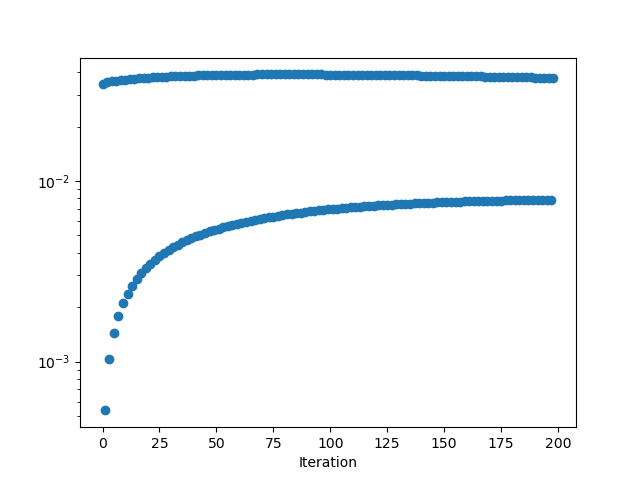

In [146]:
def f_plot_spec_iteration(arr,kx,ky):
    print(arr[1:,0,0].shape)
    plt.figure()
    plt.plot(arr[1:,kx,ky],marker='o',linestyle='')
    plt.xlabel('Iteration')
    plt.yscale('log')
    plt.show()

f_plot_spec_iteration(a_spec,0,0)
# interact(f_plot_spec_iteration,arr=fixed(a_spec),kx=IntSlider(min=0,max=a_spec.shape[1]-1,step=1),ky=IntSlider(min=0,max=a_spec.shape[2]-1,step=1))

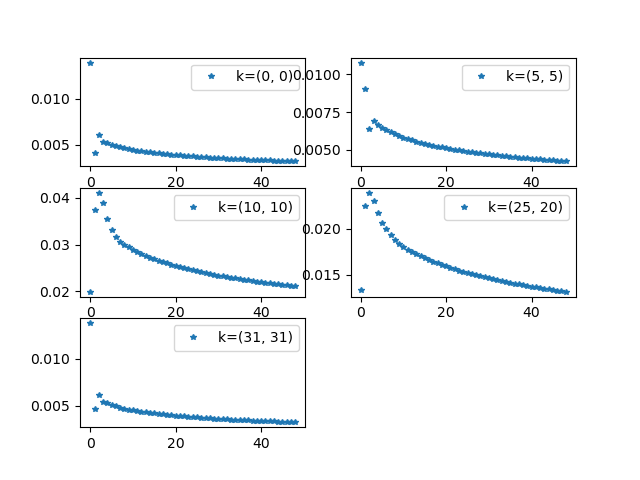

In [14]:
def f_grid_iter_plot(arr,klist):
    fig=plt.figure()

    size=len(klist)
    cols=max(size//2,1)
    cols=min(cols,4)
    rows=int(np.ceil(size/cols))
    # rows,cols=2,2
    
    for count,k in enumerate(klist):
        kx,ky=k[0],k[1]
        fig.add_subplot(rows,cols,count+1)
        plt.plot(arr[1:,kx,ky], marker='*',markersize=4,linestyle='',label="k="+str(k))
        plt.legend()
    plt.show()


klist=[(0,0),(5,5),(10,10),(25,20),(31,31)]
f_grid_iter_plot(a_spec[:50],klist)


### Compare different runs

In [15]:
# aspec_lst=[f_batch_spectrum(arr) for arr in arr_lst]
aspec_lst=[f_batch_spectrum(arr)[:200] for arr in err_lst]
labels_lst=['No MG','mg-1level_1GS','mg-1level-5GS','mg_4levels']

In [16]:
def f_compare_runs(arrlist,labellist,kx,ky):
    fig=plt.figure()

    size=len(labellist)
    cols=max(size//2,1)
    cols=min(cols,4)
    rows=int(np.ceil(size/cols))
    # rows,cols=2,2
    
    mrkrs=['o','*','v','x','H','D','H','s','8','p']
    for count,(lbl,mrkr) in enumerate(zip(labellist,mrkrs)):
        a_spec=arrlist[count]
        # fig.add_subplot(rows,cols,count+1)
        plt.plot(a_spec[1:,kx,ky], marker=mrkr,markersize=5,linestyle='',label=lbl)

        plt.legend()
    plt.yscale('log')
    plt.title('Fourier coefficient %s-%s'%(kx,ky))
    plt.show()
    
# f_compare_runs(aspec_lst[:],labels_lst[:],2,0)

In [64]:
size=arr_lst[0].shape[-1]-1
interact(f_compare_runs,arrlist=fixed(aspec_lst),labellist=fixed(labels_lst),kx=IntSlider(min=0,max=size,step=1),ky=IntSlider(min=0,max=size-1,step=1))


interactive(children=(IntSlider(value=0, description='kx', max=31), IntSlider(value=0, description='ky', max=3…

<function __main__.f_compare_runs(arrlist, labellist, kx, ky)>

### Spectrum
$$ \lambda = m^2 + 4 \sin ^2 \left( {\frac{\pi}{L} \ k_x }\right) + 4 \sin ^2 \left( {\frac{\pi}{L} \ k_y }\right) $$ 

In [65]:
def f_lambda(kx,ky,m,L):
    return (m**2+4*(np.sin(np.pi*kx/(1.0*L)))**2+4*(np.sin(np.pi*ky/(1.0*L)))**2)

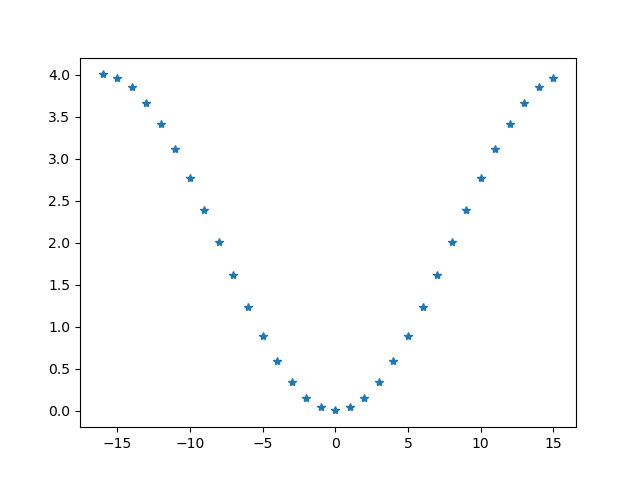

In [68]:
m=0.04;L=32
plt.figure()
x=np.arange(-L/2,L/2)
y=f_lambda(x,0,m,L)
plt.plot(x,y,linestyle='',marker='*')

#### Dataframe for spectrum

In [118]:
df_list=[]

for j in range(len(err_lst)): 
    arr_0=err_lst[j]
    cols=['iter','kx','ky','Lambda','C']
    df1=pd.DataFrame(columns=cols)
    a_spec=f_batch_spectrum(arr_0)
    arr=a_spec[:]
    print(arr.shape)
    size=int(arr_0.shape[-1])
    dict1={}
    ilist=[1,2,3,4,5,20,100,1000,3000,4999]
    # for itr in [0,1,2,3,4,5,100,500,1000,2000,3000,4000,4999]:
    iter_list=[i for i in ilist if i<arr.shape[0]]
    for itr in iter_list:
        if itr<arr.shape[0]:
            for kx in range(-size/2,size/2):
                for ky in range(-size/2,size/2):
                    vals=[itr,kx,ky,f_lambda(kx,ky,m,L),arr[itr,kx,ky]]
                    dict1=dict(zip(cols,vals))
                    # print(dict1)
                    df1=df1.append(dict1,ignore_index=True)
            # print('iter',itr)
    df1=df1.sort_values(by=['iter','Lambda','kx','ky'])
    print(df1.shape,itr)
    df_list.append(df1)


(5000, 32, 32)


TypeError: 'float' object cannot be interpreted as an integer

In [99]:
len(err_lst),len(df_list)

(4, 4)

In [100]:
df1=df_list[0]
print(iter_list)
df1

[1, 2, 3, 4, 5, 20]


,iter,kx,ky,Lambda,C
0,1.0,0.0,0.0,0.001600,0.013897
1,1.0,0.0,1.0,0.040029,0.013794
32,1.0,1.0,0.0,0.040029,0.014016
31,1.0,0.0,31.0,0.040029,0.013794
992,1.0,31.0,0.0,0.040029,0.014016
...,...,...,...,...,...
9712,4999.0,15.0,16.0,7.963171,0.436415
9743,4999.0,16.0,15.0,7.963171,0.444237
9745,4999.0,16.0,17.0,7.963171,0.444237
9776,4999.0,17.0,16.0,7.963171,0.436415


In [101]:
# ## Spectrum histogram
# df=df1[df1.iter==1]
# df.hist(column='Lambda',bins=50)
# plt.xlabel('$\lambda$')

In [102]:
# df[df.kx.isin([0,1,31])&df.ky.isin([0,1,31])]

Text(0.5, 1.0, 'Full spectrum')

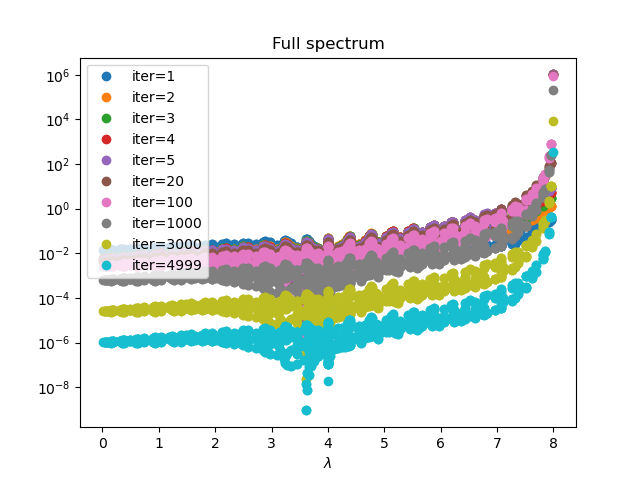

In [110]:
# Variation of fourier coefficients vs spectrum 
iter_list=np.unique(df1.iter.values).astype(int)
plt.figure()
for itr in iter_list:
    df=df1[df1.iter==itr]
    plt.plot(df.Lambda,df.C,linestyle='',marker='o',label='iter='+str(itr))
plt.legend()
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.title('Full spectrum')

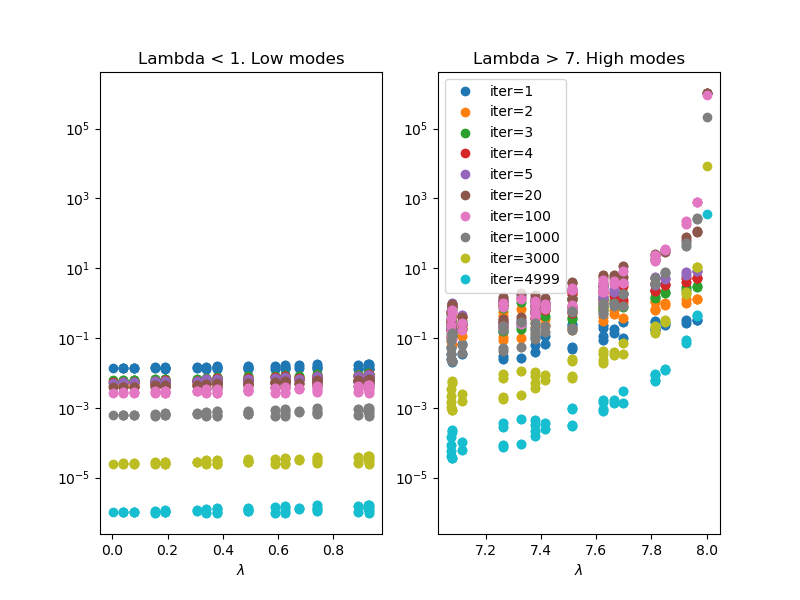

In [111]:
## Compare low and high modes

# fig,(ay1,ay2)= plt.subplots(ncols=2, sharey=True)
fig=plt.figure(figsize=(8,6))
plt.title("Fourier coefficients vs Lambda\n\n")
# Variation of fourier coefficients vs Lambda for small and large modes
# df=df1[(df1.ky<4)&(df1.kx<4)]
# # df=df1[(df1.ky>25)&(df1.kx>25)]
# df=df1[df1.Lambda>7]
plt.xticks([])
plt.yticks([])

ax1=plt.subplot(121)
df=df1[df1.Lambda<1]
for itr in iter_list:
    df2=df[df.iter==itr]
    plt.plot(df2.Lambda,df2.C,linestyle='',marker='o',label='iter='+str(itr))
plt.title('Lambda < 1. Low modes')
plt.yscale('log')
plt.xlabel('Lambda')
plt.xlabel('$\lambda$')

ax2=plt.subplot(122,sharey=ax1)
# fig.add_subplot(1,2,2)
df=df1[df1.Lambda>7]
for itr in iter_list:
    df2=df[df.iter==itr]
    plt.plot(df2.Lambda,df2.C,linestyle='',marker='o',label='iter='+str(itr))
    
ax2.set_yticklabels([])
ax2.autoscale()
plt.title('Lambda > 7. High modes')
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.legend()
plt.show()

In [56]:
# # Variation of fourier coefficients vs ks
# df=df1[(df1.iter==1)&(df1.ky==1)]
# plt.figure()
# plt.plot(df.kx,df.Lambda,linestyle='',marker='o')


In [57]:
# # Variation of fourier coefficients vs Lambda for small and large modes
# df=df1[(df1.ky<4)&(df1.kx<4)]
# # df=df1[(df1.ky>25)&(df1.kx>25)]
# df=df1[df1.Lambda>7]

# # df=df1[(df1.iter==1)&(df1.ky>28)&(df1.kx>28)]
# df.iter.values

# plt.figure()
# for itr in [1,2,4000]:
#     df2=df[df.iter==itr]
#     plt.plot(df2.Lambda,df2.C,linestyle='',marker='o',label='iter='+str(itr))
# plt.legend()
# plt.yscale('log')

In [58]:
1.0/32

0.03125